In [3]:
#  IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import manifold, datasets
from sklearn.manifold import t_sne as t_sne
from sklearn.manifold import LocallyLinearEmbedding as lle
from sklearn.metrics.pairwise import euclidean_distances
from  scipy.stats import norm
from sklearn.utils import check_array, check_random_state

# This import is needed to modify the way figure behaves
from mpl_toolkits.mplot3d import Axes3D
Axes3D
#interactive plot
#%matplotlib notebook 
#not interactive plot

from ipywidgets import *
import pickle
import time

import helpers as HP

# 0. Making of swiss roll dataset

In [10]:
# lag teppe i 2D med random points

def make_swissroll(n=1000, noise=1.0, nb_holes=0, sigma=0.4, threshold=False, random_state=None):
    """
    Make a swissroll data 
    
    Parameters
    ----------
    n : number of starting datapoints
    noise : sigma og gaussian noise in the data
    nb_holes : number of holes to make in the dataset
    sigma : sigma of the gaussian that makes the holes
    threshold : range [0-1], threshold decided the probabilitylimit if to keep or reject a point(nearby hole).
                Leaving it False makes use of a gaussian to basically downsample some holes randomly distributed.
    randomstate : any integer makes the code reprodusible.
    
    Returns
    -------
    X : The datapoints row=datapoints, col= dimensions
    t : color of the different points
    """
    generator = check_random_state(random_state)
    data_2d = make_2d_data(n, generator)
    
    # add potential holes in data
    if nb_holes > 0:
        data_2d = make_2d_holes(np.squeeze(data_2d.T), nb_holes=nb_holes, sigma=sigma,threshold=threshold).T

    X, t = transform_to_3d(data_2d)
    
    # add potiential noise to data
    if noise > 0:
        X += noise * generator.randn(3, t.size)
    
    X = X.T
    t = np.squeeze(t)
    return X, t

def make_2d_data(n, generator):
    """ generate a 2d uniformly sampled dataset"""
    t = 1.5 * np.pi * (1 + 2 * generator.rand(1, n))
    y = 4.5 * np.pi * (1 + 2 * generator.rand(1, n))
    return np.array([t, y])

def transform_to_3d(data_2d):
    """ transform 2D data to 3D with a swiss roll transformation """
    t, y = data_2d[0].reshape(1,-1), data_2d[1].reshape(1,-1)
    x = t * np.cos(t)
    z = t * np.sin(t)
    return np.concatenate((x, y, z)), t


def plot_2d(data):
    """ plots 2D data as scatterplot"""
    %matplotlib inline
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(data[0], data[1])

def plot_3d(data, color, interactive=False):
    """ 
    plots 3D data as scatterplot where you can choose interactive plot or not
    The magic %matplotlib lines are not so stable so run this function in its own process
    """
    if interactive: 
        %matplotlib notebook
    else:
        %matplotlib inline
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], c=color, cmap=plt.cm.Spectral)
    plt.show()
    
def keep_points(distance, sigma, threshold=False):
    """ Returns False if point is to be removed, True otherwise
    distance: a vector of distances to a given point. 
    sigma: variance of the gaussian
    threshold: if a value is given, then all distances that have a higher probability than threshold to be removed, 
    are removed. 
    """
    n=len(distance)
    probability_of_rejecting=norm.pdf(distance, scale=sigma)/norm.pdf(0,scale=sigma)
    if not threshold:
        return np.random.binomial(1,probability_of_rejecting)==0
    else: 
        return probability_of_rejecting < threshold
    
def make_2d_holes(data, nb_holes=3, sigma=0.1, threshold=False):
    """
    makes circular holes in 2d data if threshold is set it makes a holes with strict boundaries.
    With threshold to false it every points distance from the hole center is evaluated with a gaussian with mean=0.
    This makes it a randomly place downsampling/hole in the data.
    """
    #create distance matrix
    dist_mat = euclidean_distances(data,data)
    
    # choose the points where hole originate nb_holes
    indexes = np.arange(data[:,0].size)
    hole_centers = np.random.choice(indexes, nb_holes, replace=False)
    
    bool_list = list()
    # remove points nearby with probability
    for index in hole_centers:
        boolean_reject = keep_points(dist_mat[index], sigma, threshold=threshold)
        bool_list.append(boolean_reject)
    # put do OR operation on all the rejected point before removing
    bool_array = np.array(bool_list)
    remove_mask = np.all(bool_array, axis=0)
    
    data = data[remove_mask]
    return data


(2921, 3)
(2921,)
9.46326946398 14.1325016865 4.71577785915


<IPython.core.display.Javascript object>


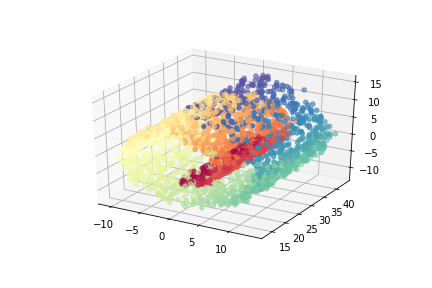

In [11]:
# to test the function    

X, color = make_swissroll(n=3000, noise=0.4, nb_holes=2, sigma=0.4, threshold=0.02, random_state=None)
print(X.shape)
print(color.shape)
print(color.mean(), color.max(), color.min())

plot_3d(X, color, interactive=True)



# 1. Artificial dataset: Swiss roll 

In [ ]:
# Author: Fabian Pedregosa -- <fabian.pedregosa@inria.fr>
# License: BSD 3 clause (C) INRIA 2011

print(__doc__)

import matplotlib.pyplot as plt

# This import is needed to modify the way figure behaves
from mpl_toolkits.mplot3d import Axes3D
Axes3D

#----------------------------------------------------------------------
# Locally linear embedding of the swiss roll

from sklearn import manifold, datasets
X, color = datasets.samples_generator.make_swiss_roll(n_samples=1000)

color = np.concatenate((color[0:600], color[800:999]))
X = np.concatenate((X[0:600], X[800:999]))
print("datalength", len(X))

print("Computing LLE embedding")
X_lle, err = manifold.locally_linear_embedding(X, n_neighbors=12,
                                             n_components=2)
print("Done. Reconstruction error: %g" % err)

#----------------------------------------------------------------------
# t-SNE of the swiss roll

print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)
print(X_tsne.shape)
print("Done. Reconstruction error: %g" % err)

#----------------------------------------------------------------------
# Plot result 3D

fig = plt.figure()

ax = fig.add_subplot(211, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)

ax.set_title("Original data")
ax = fig.add_subplot(212)
ax.scatter(X_lle[:, 0], X_lle[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Projected data')
plt.show()

#----------------------------------------------------------------------
# Plot result

fig = plt.figure()

ax = fig.add_subplot(211, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)

ax.set_title("Original data")
ax = fig.add_subplot(212)
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Projected data')
plt.show()

# 2. Real Dataset: MNIST - handwritten digits

In [ ]:
# Authors: Fabian Pedregosa <fabian.pedregosa@inria.fr>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2011

print(__doc__)
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

print("Xshape: ", X.shape)
print("yshape: ", y.shape)


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


#----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')

#----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle,
               "Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, perplexity = 30, early_exaggeration = 4, learning_rate=1000.0, 
                     n_iter=1000, metric='euclidean', init='pca', verbose=0, random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

# Additional Plots and examples

### t-SNE Perplexity

In [ ]:
# Author: Narine Kokhlikyan <narine@slice.com>
# License: BSD

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

n_samples = 300
n_components = 2
(fig, subplots) = plt.subplots(3, 5, figsize=(15, 8))
perplexities = [5, 30, 50, 100]

X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r")
    ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

# Another example using s-curve
X, color = datasets.samples_generator.make_s_curve(n_samples, random_state=0)

ax = subplots[1][0]
ax.scatter(X[:, 0], X[:, 2], c=color, cmap=plt.cm.viridis)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[1][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.viridis)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


# Another example using a 2D uniform grid
x = np.linspace(0, 1, int(np.sqrt(n_samples)))
xx, yy = np.meshgrid(x, x)
X = np.hstack([
    xx.ravel().reshape(-1, 1),
    yy.ravel().reshape(-1, 1),
])
color = xx.ravel()
ax = subplots[2][0]
ax.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.viridis)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[2][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("uniform grid, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.viridis)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


plt.show()